In [2]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [67]:
import pennylane as qml
#import numpy as np
from pennylane import numpy as np
#import tensorflow as tf
import qutip as qt
from matplotlib import pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

We also declare a 3-qubit simulator device running in Cirq.


In [68]:
dev = qml.device('default.qubit', wires=3)

Generator and Discriminator
===========================




In [69]:
def U1(w,wire):
    qml.RZ(w[0],wires = wire)
    qml.RX(w[1],wires = wire)
    qml.RZ(w[2],wires = wire)

def U2(w,wire1,wire2):
    U1(w[0:3], wire1)
    U1(w[3:6], wire2)
    qml.CNOT(wires = [wire2,wire1])
    qml.RZ(w[6],wires = wire1)
    qml.RY(w[7],wires = wire2)
    qml.CNOT(wires = [wire1,wire2])
    qml.RY(w[8],wires = wire2)
    qml.CNOT(wires = [wire2,wire1])
    U1(w[9:12], wire1)
    U1(w[12:15],wire2)

In [70]:
def real(w, **kwargs):
    U2(w,0,1)
    

def generator(w, **kwargs):
    U2(w[0:15],0,1)
    #U2(w[15:30],0,1) Erase this, be careful with overparametrization
    
def discriminator(w, **kwargs):
    U2(w[0:15],0,1)
    U2(w[15:30],1,2)
    U2(w[30:45],0,1)
    U2(w[45:60],1,2)

# Nodes

In [71]:
@qml.qnode(dev, diff_method="parameter-shift")
def real_disc_circuit(real_params, disc_weights):
    real(real_params)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))


@qml.qnode(dev, diff_method="parameter-shift")
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

QGAN cost functions
===================




In [72]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(real_params, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true


def disc_cost(disc_weights, gen_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(gen_weights, disc_weights):
    cost = -prob_fake_true(gen_weights, disc_weights)
    return cost

Initializing the weights
=================


Real state generation

In [73]:
real_params = np.random.uniform(low=-np.pi, high=np.pi, size=15)

Generator and Discriminator parameter initialization

In [74]:
init_gen_weights = np.random.uniform(low=-np.pi, high=np.pi, size=30)
init_disc_weights = np.random.uniform(low=-np.pi, high=np.pi, size=60)

gen_weights=np.array(list(init_gen_weights), requires_grad=False)
disc_weights=np.array(list(init_disc_weights), requires_grad=True)

We train in turns. We expect around 250 turns to converge. Each turn consists of 20 discriminator steps and 1 generator step.

# Define some other metrics

In [75]:
dev_state = qml.device('default.qubit', wires=2)

In [76]:
@qml.qnode(dev_state, interface="torch")
def real_circuit(w):
    U1(w[0:3], 0)
    U1(w[3:6], 1)
    qml.CNOT(wires = [1,0])
    qml.RZ(w[6],wires = 0)
    qml.RY(w[7],wires = 1)
    qml.CNOT(wires = [0,1])
    qml.RY(w[8],wires = 1)
    qml.CNOT(wires = [1,0])
    U1(w[9:12], 0)
    U1(w[12:15],1)
    return qml.state()


@qml.qnode(dev_state, interface="torch")
def gen_circuit(gen_weights):
    generator(gen_weights)
    return qml.state()

In [77]:
def fidelity(real_params,gen_weights):
    real_state = qt.Qobj(real_circuit(real_params).detach().numpy())
    gen_state = qt.Qobj(gen_circuit(gen_weights).detach().numpy())
    
    ρ_R = real_state * real_state.dag()
    ρ_G = gen_state * gen_state.dag()
    
    F = qt.fidelity(ρ_R,ρ_G)
    return F

In [78]:

def trace_distance(real_params,gen_weights):
    real_state = qt.Qobj(real_circuit(real_params).detach().numpy())
    gen_state = qt.Qobj(gen_circuit(gen_weights).detach().numpy())
    
    ρ_R = real_state * real_state.dag()
    ρ_G = gen_state * gen_state.dag()
    
    d = qt.tracedist(ρ_R,ρ_G)
    return d

------------------------------------------------------------------------------

# Mirror Descent Optimizer

Adapted from the pennylane Gradient Descent Optimizer. Since only the function apply_grad() is used, this is currently the only one implemented. Could be expanded to also make use of step().

In [ ]:
import warnings

from pennylane._grad import grad as get_gradient
from pennylane.utils import _flatten, unflatten
from pennylane.numpy import ndarray, tensor


class MirrorDescentOptimizer:
    r"""Basic mirror-descent optimizer.
    Base class for other gradient-descent-based optimizers.
    A step of the mirror descent optimizer computes the new values via the rule
    .. math::
        x^{(t+1)} = x^{(t)} - 2*\eta \nabla f(x^{(t)}). + \eta \nabla f(x^{(t-1)})
    where :math:`\eta` is a user-defined hyperparameter corresponding to step size.
    Args:
        stepsize (float): the user-defined hyperparameter :math:`\eta`
    """

    def __init__(self, stepsize=0.01):
        self.stepsize = stepsize
        

    def apply_grad(self, grad_t, grad_t_prev, args):
        r"""Update the variables to take a single optimization step. 
        Args:
            grad_t & grad_t_pref (tuple [array]): the current and previous gradient of the objective
                function 
            args (tuple): the current value of the variables :math:`x^{(t)}`
        Returns:
            list [array]: the new values :math:`x^{(t+1)}`
        """
        args_new = list(args)

        trained_index = 0
        for index, arg in enumerate(args):
            if getattr(arg, "requires_grad", True):
                
                args_new[index] = arg - 2* self.stepsize * grad_t[index] + self.stepsize * grad_t_prev[index]

                if isinstance(arg, ndarray):
                    # Due to a bug in unflatten, input PennyLane tensors
                    # are being unwrapped. Here, we cast them back to PennyLane
                    # tensors. 
                    # TODO: remove when the following is fixed:
                    # https://github.com/PennyLaneAI/pennylane/issues/966
                    args_new[index] = args_new[index].view(tensor)
                    args_new[index].requires_grad = True

        return args_new

# Training routine

In [92]:
opt1=MirrorDescentOptimizer(stepsize=0.1)
opt2=MirrorDescentOptimizer(stepsize=0.1)

In [80]:
#----- Metrics ----------------------------

Disc_cost = [] # P(R|R)-P(R|G)
Gen_cost = [] # P(R|G)
Trace_d = [] #Trace distance
F = [] #Fidelity

#-------------------------------------------

costD = lambda: disc_cost(disc_weights, gen_weights)
costG = lambda: gen_cost(gen_weights, disc_weights)

for turn in range(250):

    disc_weights=np.array(list(disc_weights), requires_grad=True)
    gen_weights=np.array(list(gen_weights), requires_grad=False)
    
    for step in range(20): #The actual ratio should be 20 to 1, according to what we discussed
        
        grad_gen_circuit_disc=qml.grad(gen_disc_circuit, argnum=1)
        grad_real_disc_circuit=qml.grad(real_disc_circuit, argnum=1) 
        grad_disc_current=grad_gen_circuit_disc(gen_weights, disc_weights)-grad_real_disc_circuit(real_params, disc_weights)
        
        if step == 0:
            #if we are in the first step, do normal gradient descent because there is no history of gradients
            grad_disc_prev = grad_disc_current
        
        #apply the optimization step
        disc_weights=np.array(opt1.apply_grad(grad_disc_current, grad_disc_prev, disc_weights), requires_grad=True)
        
        #new gradient becomes old one
        grad_disc_prev = grad_disc_current

        if step == 19:
            costD_val = costD().numpy()
            Disc_cost += [-costD_val] # P(R|R)-P(R|G)

    disc_weights=np.array(list(disc_weights), requires_grad=False)
    gen_weights=np.array(list(gen_weights), requires_grad=True)

    grad_gen_current=-qml.grad(gen_disc_circuit, argnum=0)(gen_weights, disc_weights)
    
    #generator has only one optimization step --> no history
    grad_gen_prev = grad_gen_current
    
    #do optimization step
    gen_weights=np.array(opt2.apply_grad(grad_gen_current, grad_gen_prev, gen_weights), requires_grad=True)
    
    grad_gen_prev = grad_gen_current
   
    costG_val = costG().numpy()
    Gen_cost += [-costG_val] # P(R|G)
    
    fid = fidelity(real_params,gen_weights)
    F += [fid] #Fidelity
    TrD = trace_distance(real_params,gen_weights)
    Trace_d += [TrD] #Trace distance
    
    print("P(R|R)-P(R|G): ", -costD_val)
    print("P(R|G): ", -costG_val)
    print("Fidelity: ",fid)
    print("Trace distance: ",TrD)
    print("------------------------------")
    

P(R|R)-P(R|G):  0.6821827709448021
P(R|G):  0.1747175439711352
Fidelity:  0.23555926414809886
Trace distance:  0.9718599942632062
------------------------------
P(R|R)-P(R|G):  0.7856350325765663
P(R|G):  0.13571958689250818
Fidelity:  0.2602804031326382
Trace distance:  0.9655330794108548
------------------------------
P(R|R)-P(R|G):  0.8432489238979268
P(R|G):  0.12539237552060778
Fidelity:  0.2852704221973923
Trace distance:  0.9584470780378339
------------------------------
P(R|R)-P(R|G):  0.9027222025018512
P(R|G):  0.09387985048990122
Fidelity:  0.3095662392649391
Trace distance:  0.950877888488272
------------------------------
P(R|R)-P(R|G):  0.9291624324747805
P(R|G):  0.06916897815336831
Fidelity:  0.3328775947451341
Trace distance:  0.9429700550971727
------------------------------
P(R|R)-P(R|G):  0.9359423179837236
P(R|G):  0.05571794874310859
Fidelity:  0.3556399539448679
Trace distance:  0.934623046992697
------------------------------
P(R|R)-P(R|G):  0.9326771936902036
P

P(R|R)-P(R|G):  -0.008143929447247844
P(R|G):  0.7988463863398517
Fidelity:  0.9970549225781387
Trace distance:  0.0766910334073935
------------------------------
P(R|R)-P(R|G):  0.009875433932424849
P(R|G):  0.7803690323793361
Fidelity:  0.9972729977506132
Trace distance:  0.07380109059204619
------------------------------
P(R|R)-P(R|G):  0.010986287765514247
P(R|G):  0.7723050039047026
Fidelity:  0.9977495772929506
Trace distance:  0.06705063734828787
------------------------------
P(R|R)-P(R|G):  0.023869027728351755
P(R|G):  0.7109325873882753
Fidelity:  0.9990449919221652
Trace distance:  0.043693415369132814
------------------------------
P(R|R)-P(R|G):  0.018111705773114495
P(R|G):  0.710061155673748
Fidelity:  0.9998345953202797
Trace distance:  0.018187983729970825
------------------------------
P(R|R)-P(R|G):  0.004687119788319927
P(R|G):  0.7340451448446657
Fidelity:  0.9994927005898332
Trace distance:  0.031849015534561154
------------------------------
P(R|R)-P(R|G):  -0.0

P(R|R)-P(R|G):  3.701169186876019e-05
P(R|G):  0.9070859053462353
Fidelity:  0.9996179545775199
Trace distance:  0.027640144481188886
------------------------------
P(R|R)-P(R|G):  0.00038094744593986096
P(R|G):  0.9054066929855707
Fidelity:  0.9995696037595705
Trace distance:  0.029336601271687517
------------------------------
P(R|R)-P(R|G):  -0.000362548353484482
P(R|G):  0.9104519859181752
Fidelity:  0.9995441190141983
Trace distance:  0.030192225792752228
------------------------------
P(R|R)-P(R|G):  -0.0006465860915368937
P(R|G):  0.9185893623903448
Fidelity:  0.999550998376457
Trace distance:  0.02996387356297494
------------------------------
P(R|R)-P(R|G):  0.0004665157348368032
P(R|G):  0.9198401229457962
Fidelity:  0.9996047246285316
Trace distance:  0.028114229028170318
------------------------------
P(R|R)-P(R|G):  0.0021734651275157058
P(R|G):  0.9111890820316617
Fidelity:  0.9997046133806279
Trace distance:  0.024304235011229143
------------------------------
P(R|R)-P(R

KeyboardInterrupt: 

In [81]:
F = np.array(F)
Gen_cost = np.array(Gen_cost)
Disc_cost = np.array(Disc_cost)
Trace_d = np.array(Trace_d)

In [82]:
print(max(F))
print(F[-1])

0.9999805833197749
0.9999417331656822


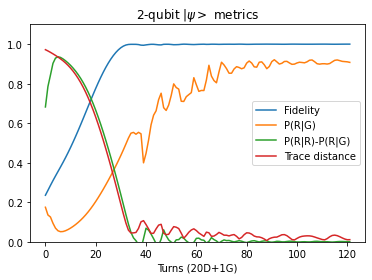

In [83]:
plt.plot(F, label='Fidelity')
plt.plot(Gen_cost, label='P(R|G)')
plt.plot(Disc_cost, label='P(R|R)-P(R|G)')
plt.plot(Trace_d, label='Trace distance')
plt.ylim([0,1.1])
plt.xlabel('Turns (20D+1G)') 
plt.title("2-qubit $|\psi>$ metrics")
plt.legend()
plt.savefig('2qubitlearning.png', format='png')

In [84]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_state_city

C:\Users\sarah\anaconda3\lib\site-packages\qiskit\visualization\bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


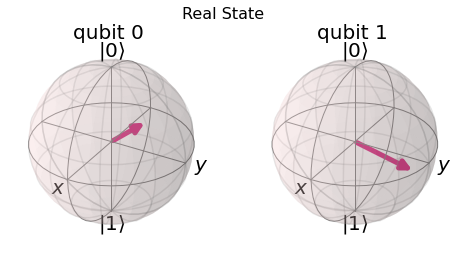

In [85]:
real_state = qt.Qobj(real_circuit(real_params).detach().numpy()).full() 
plot_bloch_multivector(Statevector(real_state), title="Real State", reverse_bits=False)


C:\Users\sarah\anaconda3\lib\site-packages\qiskit\visualization\bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


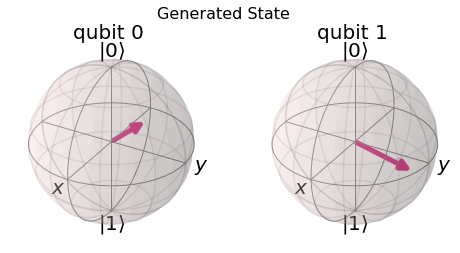

In [87]:
gen_state = qt.Qobj(gen_circuit(gen_weights).detach().numpy()).full()
plot_bloch_multivector(Statevector(gen_state), title="Generated State", reverse_bits=False)



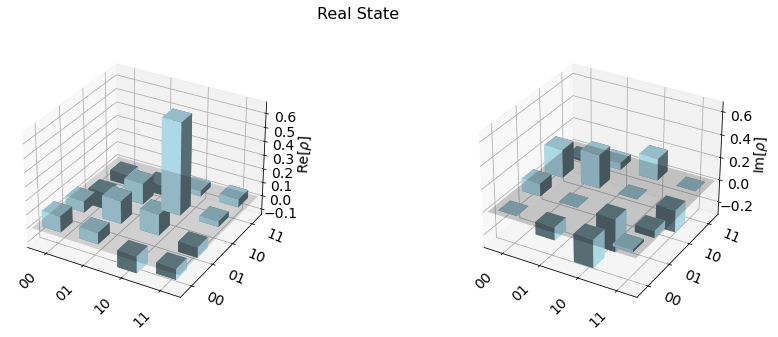

In [88]:
plot_state_city(Statevector(real_state), color=['lightblue', 'lightblue'],
     title="Real State")

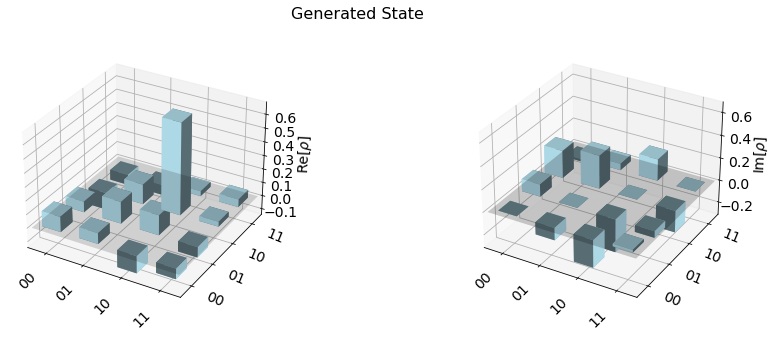

In [89]:
plot_state_city(Statevector(gen_state), color=['lightblue', 'lightblue'],
     title="Generated State")

In [ ]:
print(real_state)
print(gen_state)